In [75]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time

os.chdir("/Volumes/ExtraHDD2/DS_Assignments_Data/ADM_2")

In [5]:
posts = pd.read_csv("instagram_posts.csv", delimiter="\t", parse_dates=[5], infer_datetime_format=True)
profiles = pd.read_csv("instagram_profiles.csv", delimiter="\t")

In [50]:
# Answer to first question of RQ6
# Relatively trivial
# I spoke with another colleague, and it came up the fact that we could exploit the fact the average change in a signal is just the value at an extreme minus the value at the other extreme divided by the length minus 1

differences_array = posts[['profile_id', "cts"]].groupby('profile_id').max()-posts[['profile_id', "cts"]].groupby('profile_id').min()
differences_array["count"] = posts['profile_id'].value_counts() # Here the indexing of differences_array (the profile_id) is used for the alignment
differences_array = differences_array[differences_array["count"] != 1]
differences_array["cts"] /= differences_array["count"]-1
avg_timedelta = differences_array["cts"].mean()
# Basic sexagesimal calculus to get the right format, i.e. days/hours/minutes (3600 seconds in an hour, the resulting modulo (remainder minutes) is used as to calculate the minutes)
print("Average time between two posts: {} days, {} hours, {} minutes".format(avg_timedelta.days, avg_timedelta.seconds//3600, (avg_timedelta.seconds % 3600)//60))

Average time between two posts: 76 days, 17 hours, 6 minutes


In [102]:
differences_array = posts[["sid_profile", "cts"]].groupby("sid_profile").max() - posts[["sid_profile", "cts"]].groupby("sid_profile").min()
differences_array = differences_array[differences_array!=-1]
differences_array["count"] = posts["sid_profile"].value_counts() # Here the indexing of differences_array (the sid_profile) is used for the alignment

differences_array = differences_array[differences_array.index!=-1]
differences_array["cts"] /= differences_array["count"]-1

# Idea that I had talking with other colleagues, in order to remove (some) noise consider only users which have more than the mean number of posts in the posts dataset
differences_array = differences_array[differences_array["count"] >= differences_array["count"].mean()]
sid_profile_query = differences_array.sort_values(by="cts").head(3).index.tolist()
print(profiles.set_index("sid").loc[sid_profile_query, ["profile_name", "followers", "following"]].to_markdown())

|     sid | profile_name     |   followers |   following |
|--------:|:-----------------|------------:|------------:|
| 3634358 | bowerfoldevents  |          47 |          10 |
| 2642398 | cauitafotografia |         631 |        1494 |
| 4185216 | shaklee_byfatyn  |        1063 |         232 |


In [101]:
differences_array

,cts,count
sid_profile,,
1186,18 days 04:34:02.628571428,36
1187,14 days 15:43:24.950000,21
1188,34 days 20:52:37.285714285,15
1191,72 days 02:37:33.473684210,20
1196,5 days 17:14:52.583333333,13
...,...,...
4510778,6 days 18:43:07.800000,16
4510780,16 days 03:53:41.681818181,23
4510781,5 days 12:49:08.619047619,22


In [116]:
# Answer to second question, again relatively trivial

## Not to be included in the notebook because there is the function definition upstream
def time_interval_obs(interval_list: list[tuple[str | time, str | time]], time_df: pd.DataFrame,
                      time_col: str | None = None) -> None:

    if not time_col:
        dtypes_series = time_df.dtypes.index[time_df.apply(pd.api.types.is_datetime64_any_dtype)]
        if dtypes_series.empty:
            raise ValueError(
                "The dataframe has no columns for time, you need to pass a dataframe which has at least one")
        elif len(dtypes_series) != 1:
            raise TypeError("The dataframe has more than one column with datetime 64 dtype.\n\
                            You need to explicitly tell the function which one to use")
        else:
            time_col = dtypes_series[0]

    try:
        time_df = pd.Series(np.zeros(len(time_df))).set_axis(time_df[time_col])
    except KeyError:
        raise KeyError("The column you specified does not exist in the dataframe")

    n_posts_int_list = [len(time_df.between_time(*interval)) for interval in interval_list]

    plt.figure(figsize=(13, 7))
    if all([isinstance(x, time) for couple in interval_list for x in couple]):
        interval_list = [[str(x) for x in y] for y in interval_list]
        plt.bar(["|".join(x) for x in interval_list], n_posts_int_list)
    elif all([isinstance(x, str) for couple in interval_list for x in couple]):
        plt.bar(["|".join(x) for x in interval_list], n_posts_int_list)
    else:
        raise TypeError("The inserted interval list needs to have elements of type datetime.time or string")
    plt.xlabel("Time Interval")
    plt.ylabel("Number of posts")
    plt.xticks(rotation=20)
    plt.show()

    return None

In [117]:
grouped_hourly_posts = posts[["cts", "numbr_likes", "number_comments"]].groupby(posts.cts.dt.hour)
likes_comments_hourly = grouped_hourly_posts.mean(numeric_only=True)

In [118]:
# Top 3 time intervals for likes
hours_best_like = likes_comments_hourly["numbr_likes"].sort_values(ascending=False).index[:3]
intervals_best_like = [(datetime.strptime(str(x), "%H.0").time(), (datetime.strptime(str(x), "%H.0") + timedelta(hours = 1)).time()) for x in hours_best_like]

In [119]:
hours_best_comment = likes_comments_hourly["number_comments"].sort_values(ascending=False).index[:3]
intervals_best_comment = [(datetime.strptime(str(x), "%H.0").time(), (datetime.strptime(str(x), "%H.0") + timedelta(hours = 1)).time()) for x in hours_best_comment]

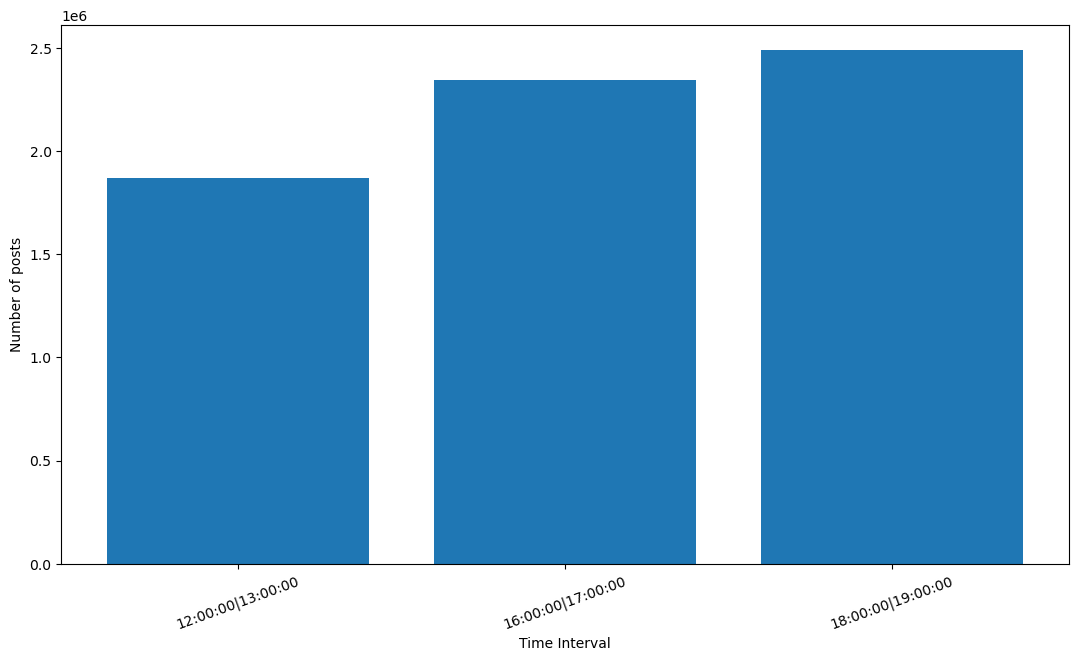

In [121]:
# Plot number of posts for time intervals with the highest average number of likes
intervals_best_like.sort(key=lambda x:x[0])
time_interval_obs(intervals_best_like, posts)

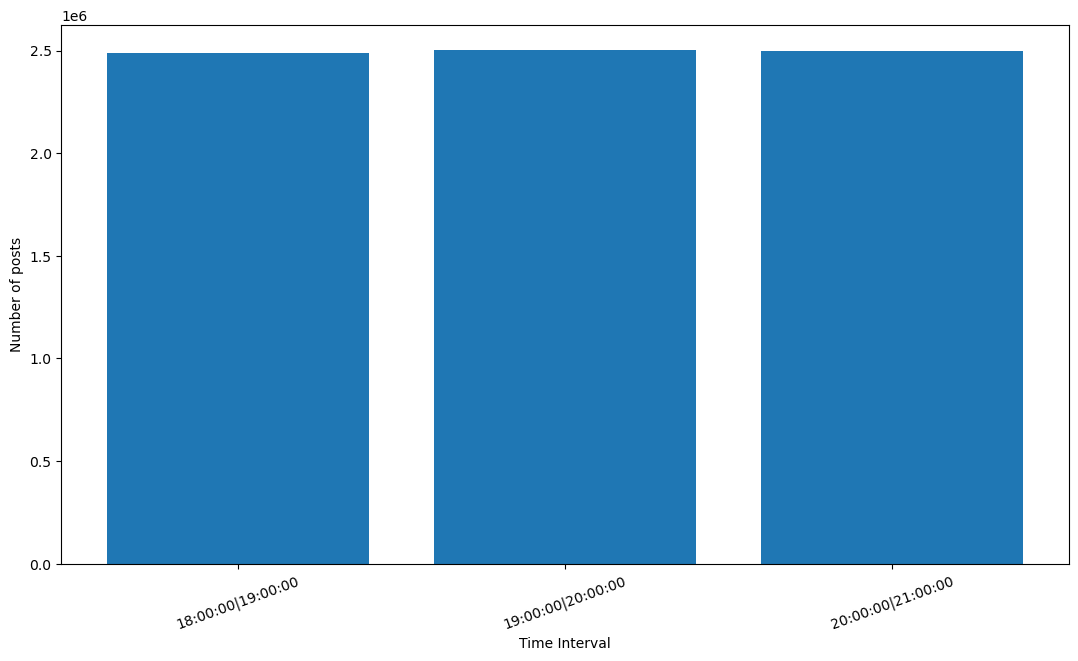

In [122]:
# Plot number of posts for time interval with the highest average number of comments
intervals_best_comment.sort(key=lambda x:x[0])
time_interval_obs(intervals_best_comment, posts)